# Data 620 Project 1
### Centrality Measures
### Steven Ellingson

For assignment 1, I pulled in the genres for a movie dataset I got from Kaggle:
https://www.kaggle.com/rounakbanik/the-movies-dataset
For assignment 2, I loaded up Forrest Gump to look at the social networks based on a dataset from Harvard Dataverse:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/T4HBA3

The dataverse dataset is great as it provides the social network for the movie, but it doesn't list any other information about the characters. So, for a categorical variable, I decided to take a movie series and connect the characters between them into one network. There are quite a few series I could use (Back to the Future, Star Wars) but I decided on one I'm familiar with that had a lot of different characters in it: The Lord of the Rings.

The dataset only has the first "Fellowship of the Ring" and the third "Return of the King" for whatever reason, but that works for my purposes.  I can connect the two, and add a categorical variable that denotes if the character exists in the first, the third, or both movies.
These next few cells are loading the Harvard Dataset, again the same as in Project 1.

In [1]:
import pandas as pd
import numpy as np
import re
import itertools
from  matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
import collections
import warnings
import os
import xmltodict

warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\steven.ellingson\\PycharmProjects\\cuny')

%matplotlib inline


In [2]:
meta = pd.read_csv('data/movie_galaxies/network_metadata.tab', delimiter='\t')
meta.head()

,GexfID,Title,IMDB_id,ReleaseDate,Slug,WeightedDegree,Modularity,PathLength,Diameter,ClusteringCoefficient,ConnectedComponents,Density,Edges,Characters
0,1,10 Things I Hate About You,tt0147800,1999,10-Things-I-Hate-About-You,"13,040","0,194","1,779","3,000","0,567","3,000","0,233",225,25
1,2,12,tt0488478,2007,12,"4,227","0,517","2,170","3,000","0,610","6,000","0,077",102,42
2,3,Twelve and Holding,tt0417385,2005,Twelve-and-Holding,"7,333","0,473","2,449","4,000","0,593","2,000","0,140",139,26
3,5,127 Hours,tt1542344,2010,127-Hours,"3,833","0,160","1,722","2,000","0,339","4,000","0,152",33,11
4,6,1492: Conquest of Paradise,tt0103594,1992,1492:-Conquest-of-Paradise,"7,941","0,350","2,043","4,000","0,705","1,000","0,153",164,34


I've created the following functions for working with this data.
There is a a file for each movie with the graph data. These functions should allow you to find a movie and create a graph.

In [3]:
def load_movie_by_id(id):
    #Take an ID and load the movie into a dictionary.
    with open('data/movie_galaxies/' + str(id) + '.gexf') as fd:
        md = xmltodict.parse(fd.read())
    if (md['gexf']):
        return(md['gexf'])
    
def load_movie_by_keyword(keyword):
    #Search for a movie and load it if it finds only 1.
    #This is super basic, could expand this with some fuzzy text algorithm
    results = meta[meta['Title'].str.contains(keyword, case=False)]
    if len(results)==1:
        print('Found!' + str(results['Title'].iloc[0]))
        return(load_movie_by_id(results['GexfID'].iloc[0]))
    elif len(results) > 1:
        c = results['GexfID'].astype(str) + ': ' + results['Title']
        c.str.cat(sep = ',\n')
        print("Too Many Movies! Use more keywords or select by ID:")
        print(c)
    else:
        print("Didn't Find any movies with those Keywords!")

def get_nodes(md):
    #Takes the loaded dictionary and returns a dictionary of the nodes
    
    #Create a blank Data Frame
    d = dict()
    
    #Loop through and add the id and label
    for x in md['graph']['nodes']['node']:
        d.update({x['@id']: x['@label']})
    return(d)

def get_edges(md, weights = True):
    #Takes the dictionary and returns a list of edges.
    #Each edge is a tuple with the relevant ids and the weight.
    e = []
    i = 0
    for x in md['graph']['edges']['edge']:
        i = i+1
        if weights:
            #Need to dig in a bit further to get the weights        
            weight = 0
            for y in x['attvalues']['attvalue']:
                if (y['@for']=='weight'):
                    weight = float(y['@value'])
            
            if weight < 1:
                #If we didn't find a weight print an error message but set to 1.
                print("No weight Found for node # " + str(i) + "!")
                weight = 1
                
            e.append((x['@source'],x['@target'],weight))
        else:
            e.append((x['@source'],x['@target']))

    return(e)

In [4]:
fotr = load_movie_by_keyword('fellowship of the ring')
rotk = load_movie_by_keyword('return of the king')

Found!The Lord of the Rings: The Fellowship of the Ring
Found!The Lord of the Rings: The Return of the King


The functions found and loaded the movies.  Below I will pull out the nodes and edges.  I will do a first attempt at merging the nodes as well. 

In [5]:
f_nodes = get_nodes(fotr)
f_edges = get_edges(fotr)
f_node_df = pd.DataFrame(list(f_nodes.items()), columns=['id','label'])
r_nodes = get_nodes(rotk)
r_edges = get_edges(rotk)
r_node_df = pd.DataFrame(list(r_nodes.items()), columns=['id','label'])
node_df = f_node_df.merge(r_node_df,left_on='label', right_on = 'label', how = 'outer', suffixes = ('_fotr', '_rotk'))
node_df.sort_values('label')

,id_fotr,label,id_rotk
0,3170593,ARAGORN,3173660
1,3169688,ARWEN,3174448
2,3166541,BILBO,3180709
3,3170391,BOROMIR,NaN
4,3168859,BUTTERBUR,NaN
24,NaN,DEAGOL,3173218
25,NaN,DENETHOR,3174733
5,3170054,ELROND,3174453
26,NaN,EOMER,3175487
27,NaN,EOWYN,3173599


This is pretty close to what we're looking for - one list of nodes and an indication of which movie(s) they belong to. There are a few issues though "FRO DO" is a type, and "STRIDER" is just what Aragorn is called early on.  I will re-map these to the nodes.

In [6]:
label_fixes = {'FRO DO': 'FRODO', 'STRIDER': 'ARAGORN', 'GOLLUM OS': 'GOLLUM'}

for id, label in f_nodes.items():
    if label in label_fixes:
        f_nodes[id] = label_fixes[label]
for id, label in r_nodes.items():
    if label in label_fixes:
        r_nodes[id] = label_fixes[label]
f_node_df = pd.DataFrame(list(f_nodes.items()), columns=['id','label'])
r_node_df = pd.DataFrame(list(r_nodes.items()), columns=['id','label'])
node_df = f_node_df.merge(r_node_df,left_on='label', right_on = 'label', how = 'outer', suffixes = ('_fotr', '_rotk'))
node_df.sort_values('label')

,id_fotr,label,id_rotk
0,3170593,ARAGORN,3173660
1,3169052,ARAGORN,3173660
2,3169688,ARWEN,3174448
3,3166541,BILBO,3180709
4,3170391,BOROMIR,NaN
5,3168859,BUTTERBUR,NaN
25,NaN,DEAGOL,3173218
26,NaN,DENETHOR,3174733
6,3170054,ELROND,3174453
27,NaN,EOMER,3175487


OK, these are now fixed.  There are duplicates now, but we will take care of that later.  I will re-map the edges to the labels and do away with the id numbers.

In [7]:
edges = [(f_nodes[x[0]],f_nodes[x[1]],x[2]) for x in f_edges]
edges.extend([(r_nodes[x[0]],r_nodes[x[1]],x[2]) for x in r_edges])
edges[:5]

[('ARAGORN', 'BOROMIR', 5.0),
 ('ARAGORN', 'GIMLI', 4.0),
 ('ARAGORN', 'LEGOLAS', 7.0),
 ('ARAGORN', 'SARUMAN', 1.0),
 ('ARWEN', 'FRODO', 1.0)]

In [8]:
edges[-5:]

[('THEODEN', 'MERRY', 2.0),
 ('WITCH KING', 'EOWYN', 1.0),
 ('WITCH KING', 'GIMLI', 1.0),
 ('WITCH KING', 'GOTHMOG', 1.0),
 ('WITCH KING', 'THEODEN', 1.0)]

OK, so we have all of our edges from BOTH movies now. I am going to put these into a dataframe to make the next steps easier.

In [9]:
edge_df = pd.DataFrame(edges,columns = ('source', 'target','weight'))

The next step is to combine and simplify this, so that each edge is only listed once. Let's switch it so the first alphabetically is always first. Order doesn't matter in this dataset and we want to make sure they are consistent.

In [10]:
switch = edge_df['source'] > edge_df['target']
edge_df.loc[switch, ['source', 'target']] = (
    edge_df.loc[switch, ['target','source']].values)

Now let's collapse our dataset.  For any edge listed twice, we will just add the weight together into one. 

In [11]:
edge_df = edge_df.groupby(['source','target'], as_index=False).sum()

Let's use the id columns to add a new column that tells us which movies the character was in.
Then we can remove the duplicates. We don't need the ID numbers anymore either as they have been replaced in our edge df.

In [12]:

for index, row in node_df.iterrows():
    switch_dict = {
        'FalseFalse': 'BOTH',
        'FalseTrue': 'FOTR',
        'TrueFalse': 'ROTK'
    }
    node_df.loc[index,'movie'] = switch_dict[str(pd.isnull(row['id_fotr'])) + str(pd.isnull(row['id_rotk']))]

node_df = node_df[['label','movie']]
node_df.drop_duplicates(inplace=True)
node_df


node_df.head()

,label,movie
0,ARAGORN,BOTH
2,ARWEN,BOTH
3,BILBO,BOTH
4,BOROMIR,FOTR
5,BUTTERBUR,FOTR


OK, now we can create our graph, and start looking at centrality measures

In [13]:
G=nx.from_pandas_edgelist(edge_df, 'source', 'target', edge_attr=True)

I'm going to make a dictionary of measures I want to calculate, and loop through them to add them to the node dataframe. 


In [14]:
measure_dict = {
    'degree': nx.degree_centrality,
    'closeness': nx.closeness_centrality,
    'betweenness': nx.betweenness_centrality,
    'eigenvector': nx.eigenvector_centrality
}

In [15]:
for col_name, measure in measure_dict.items():
    m = measure(G)
    node_df[col_name] = node_df['label'].replace(m)



I'll sort the dataset by degree centrality:

In [16]:
node_df.sort_values('degree',ascending=False).head(10)

,label,movie,degree,closeness,betweenness,eigenvector
11,GANDALF,BOTH,0.536585,0.661290,0.194765,0.305553
8,FRODO,BOTH,0.512195,0.602941,0.137073,0.297581
0,ARAGORN,BOTH,0.487805,0.594203,0.046339,0.309143
22,SAM,BOTH,0.487805,0.602941,0.137331,0.282850
21,PIPPIN,BOTH,0.463415,0.621212,0.104986,0.274633
19,MERRY,BOTH,0.463415,0.621212,0.111551,0.283173
13,GIMLI,BOTH,0.463415,0.602941,0.098028,0.278125
6,ELROND,BOTH,0.317073,0.546667,0.008745,0.246970
4,BOROMIR,FOTR,0.292683,0.539474,0.005676,0.231673
17,LEGOLAS,BOTH,0.268293,0.525641,0.004047,0.220548


And by eigenvector centrality:

In [17]:
node_df.sort_values('eigenvector',ascending=False).head(10)

,label,movie,degree,closeness,betweenness,eigenvector
0,ARAGORN,BOTH,0.487805,0.594203,0.046339,0.309143
11,GANDALF,BOTH,0.536585,0.661290,0.194765,0.305553
8,FRODO,BOTH,0.512195,0.602941,0.137073,0.297581
19,MERRY,BOTH,0.463415,0.621212,0.111551,0.283173
22,SAM,BOTH,0.487805,0.602941,0.137331,0.282850
13,GIMLI,BOTH,0.463415,0.602941,0.098028,0.278125
21,PIPPIN,BOTH,0.463415,0.621212,0.104986,0.274633
6,ELROND,BOTH,0.317073,0.546667,0.008745,0.246970
4,BOROMIR,FOTR,0.292683,0.539474,0.005676,0.231673
17,LEGOLAS,BOTH,0.268293,0.525641,0.004047,0.220548


Well nothing too interesting here - the list is almost the exact same. Let's look at summary statistics for the groups and see if anything interesting pops up.

In [18]:
round(node_df.groupby('movie').mean(),2)

,degree,closeness,betweenness,eigenvector
movie,,,,
BOTH,0.35,0.56,0.06,0.22
FOTR,0.12,0.45,0.01,0.10
ROTK,0.10,0.42,0.02,0.05


No big surprise here, that characters in both movies are much more closely connected.  It is interest that while the degree centrality is fairly close between FOTR (first film) and ROTK (third film), the eigenvector centrality is much higher for the characters in the first film only.  Let's plot these two metrics to see how they correlate.

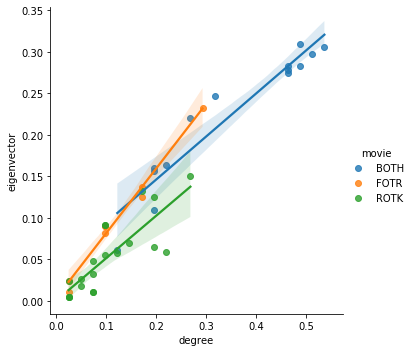

In [19]:
sns.lmplot('degree','eigenvector', hue = 'movie',data = node_df)
plt.show()

Very strong relationship here, with a maybe a few points that don't follow the trend very well.
Again, we see the members who are in both movies score very highly in both metrics. And again we see the characters who are just in the first film score more highly in eigenvector centrality as compared to members who are just in the third film. Let's add labels to our graph to try to come up with some explanations. 

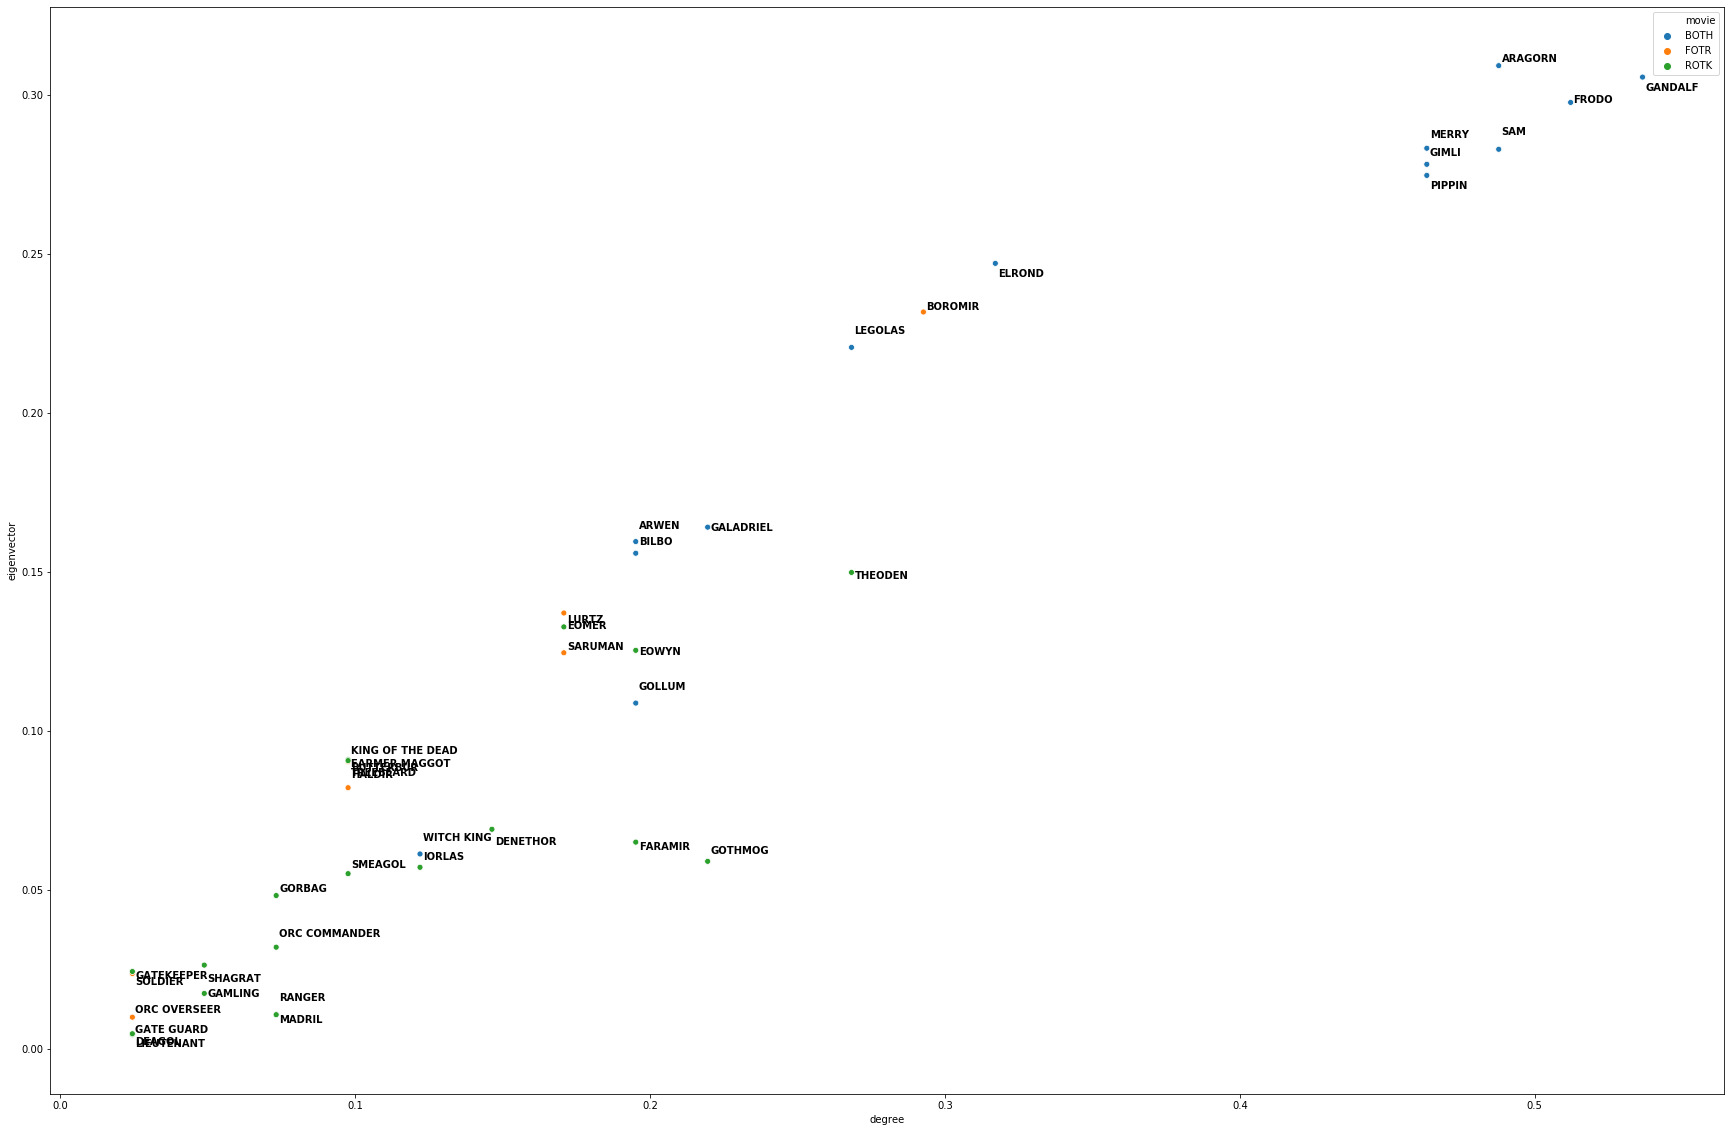

In [20]:
plt.figure(figsize=(30,20))
p1 = sns.scatterplot('degree','eigenvector', hue ='movie',data = node_df)
for key, row  in node_df.iterrows():
     p1.text(row.degree+0.001, row.eigenvector + np.random.uniform(-0.005,0.005), 
     row.label, horizontalalignment='left', 
             size='medium', color='black', weight='semibold')

An interesting point is Lurtz and Gothmog. Lurtz is sort of the head bad-guy in the first film, Gothmog plays a very similar role in the third. Why the large gap in eigenvector centrality? I believe that, in general the story became much broader as the story goes on. What starts as a story of a fellowship, all traveling together, turns into many separate stories as we get to the third film. So characters introduced at the beginning but die off or aren't heard from again interact with more of the core group.  Characters who are introduced later can only interact with some of that group, because they are all in different places for much of the movie.

Let's draw our graph and see if it looks similar.

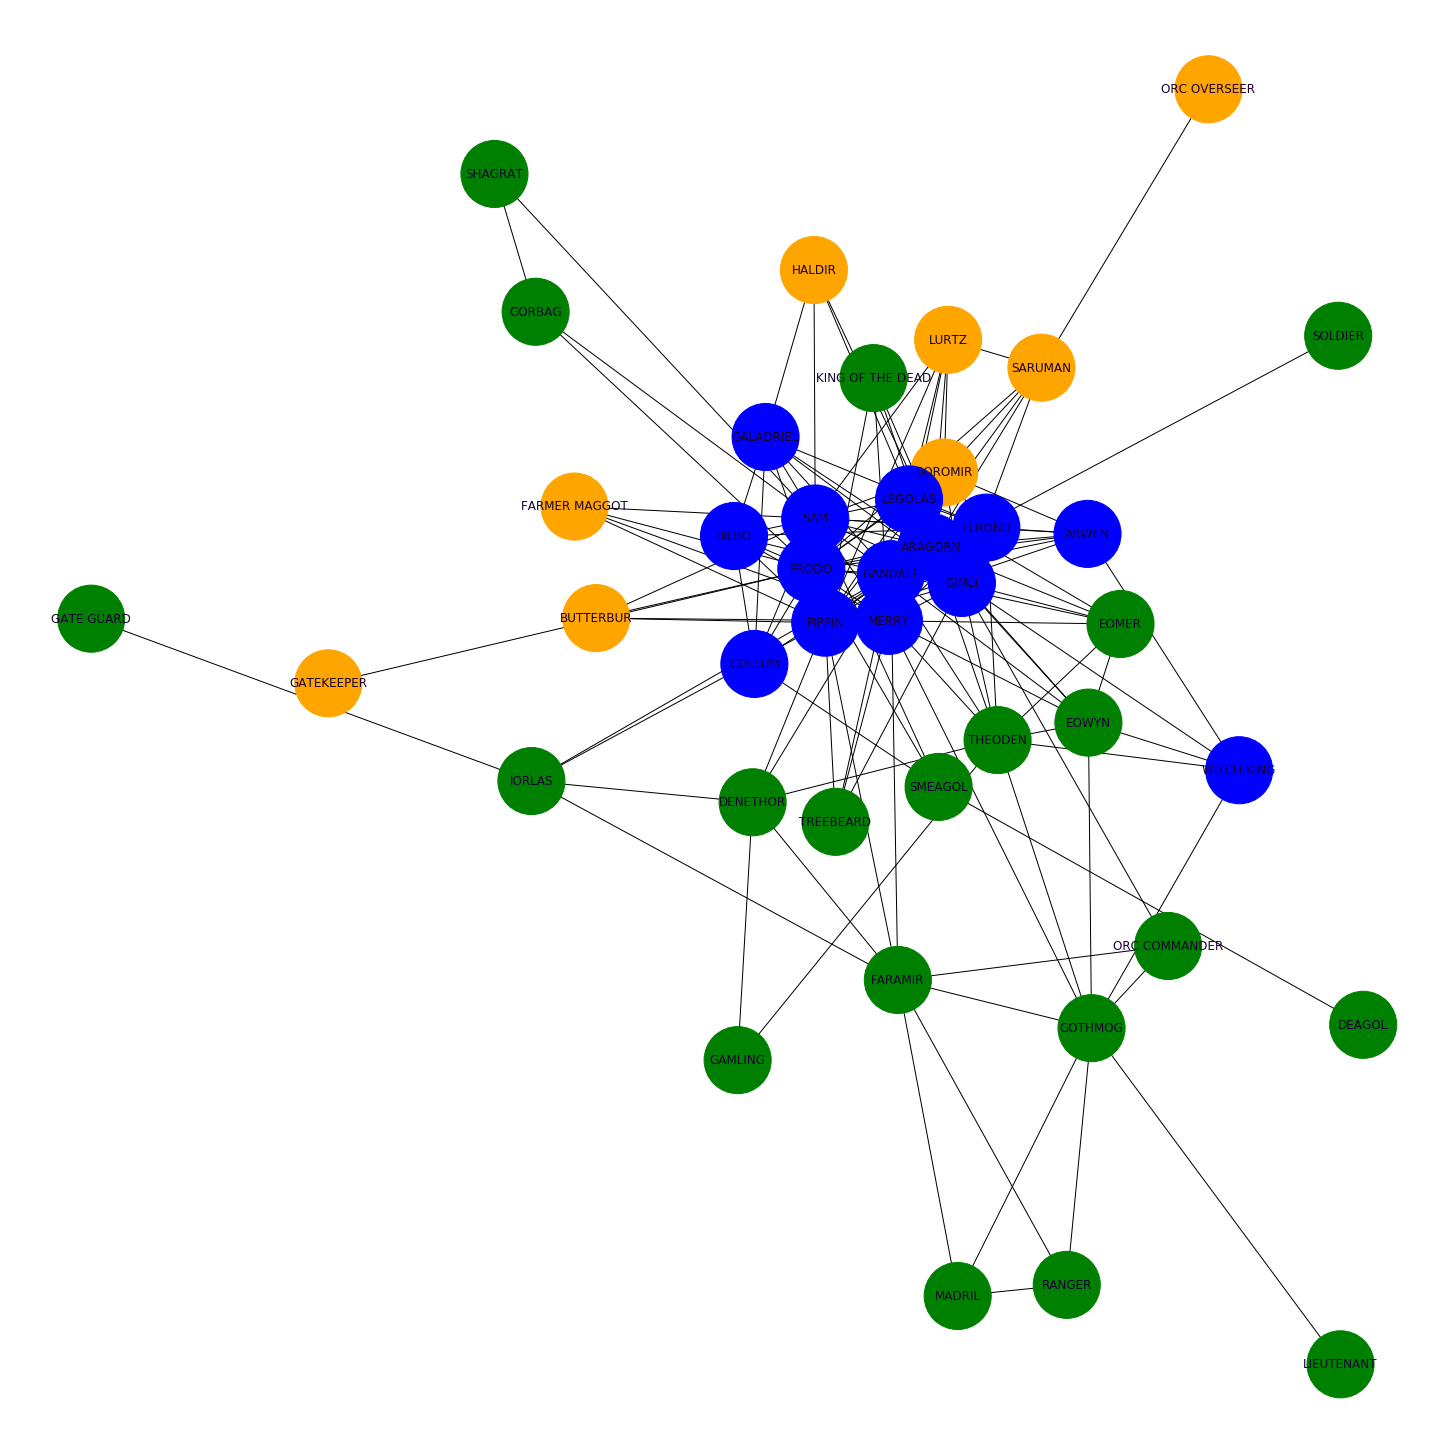

In [21]:
plt.figure(figsize=(20,20))
color_map = []
for node in G:
    movie = node_df.movie[node_df['label']==node].iat[0]
    if movie=='BOTH':
        color_map.append('blue')
    elif movie == 'FOTR':
        color_map.append('orange')
    else:
        color_map.append('green')
nx.draw(G, node_color=color_map, with_labels=True,
                 node_size = 4500,
                 font_size = 12,
                 font_color = '#1a0033')
plt.show()
    


This tells a similar story.  The "First movie only" group is closely related with the core "Both Movies" group. The characters introduced in the third film are much more loosly wound.

# Conclusions
If you're familiar wiht the Lord of the Rings, this graph tells the story pretty well. What starts as a small "Fellowship" that is moving as one, turns into a branching narrative. The large "Fellowship" turns into two or three separate groups. As new characters are introduced, they often only interact with one of those smaller groups.